In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.optim import Adam

from core.audio_handler import load_dataset
from core.audio_model import AudioModel
from core.dataset_handler import DatasetHandler

In [2]:
training_epochs = 10
dataset_length = 100

In [3]:
dataset_handler = DatasetHandler()
dataset = load_dataset()
train_loader, val_loader = dataset_handler.split_dataset_into_data_loaders(dataset, dataset_length)

print('Finished data preparation')

Finished data preparation


In [4]:
model = AudioModel()
model.init_weights()
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

print('Model initialized')

Model initialized


In [5]:
train_losses = []
val_losses = []

for epoch in range(training_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)

    print(
        f"Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

print('Finished Training')

Epoch 1, Training Loss: 495831506352842211328.0000, Validation Loss: 258837864081120034816.0000
Epoch 2, Training Loss: 439190444563719651328.0000, Validation Loss: 238031359146993909760.0000
Epoch 3, Training Loss: 405988889523172409344.0000, Validation Loss: 230045122409340600320.0000
Epoch 4, Training Loss: 385265651484227076096.0000, Validation Loss: 214171901848673320960.0000
Epoch 5, Training Loss: 352480802554513850368.0000, Validation Loss: 182242849438151213056.0000
Epoch 6, Training Loss: 298547415692138577920.0000, Validation Loss: 149992715443062702080.0000
Epoch 7, Training Loss: 248719703764120698880.0000, Validation Loss: 118240218211682353152.0000
Epoch 8, Training Loss: 211435540663557423104.0000, Validation Loss: 108025164751899197440.0000
Epoch 9, Training Loss: 193709499193966657536.0000, Validation Loss: 102061239960004984832.0000
Epoch 10, Training Loss: 180204057132505694208.0000, Validation Loss: 93665264716702810112.0000
Finished Training


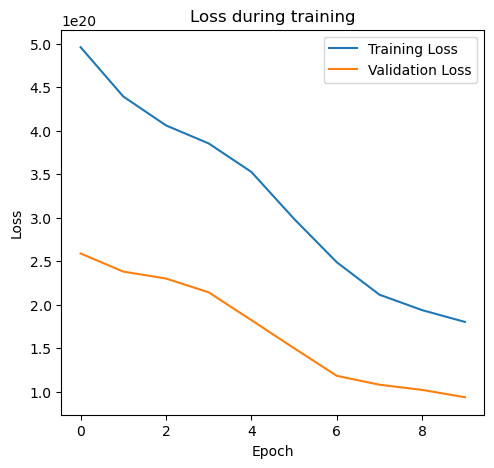

In [6]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during training')
plt.legend()

plt.show()

In [7]:
model.save()
print('Model saved')

Model saved
